In [1]:
import numpy as np
import pandas as pd
import random

from dataclasses import dataclass

from simulation.domain.model import construct_well, h_lim, betta_G_lim
from simulation.service_layer.services import get_dict_for_data, build_plot, PlotData, Scale
from simulation.domain.meter import Meter, add_noise

In [2]:
# Начальные условия
M_q = 0.5
epsilon = 0.00001
K_NUMBERS = 45000  # Количество точек моделирования
dt = 0.0001  # Суток

In [3]:
w_program = {2: 1.065556, 3: 0.9335, 3.7: 1}

well = construct_well()
well.set_w_program(w_program)


df = well.simulate(K_NUMBERS, dt, M_q, epsilon, get_dict_for_data())
df = pd.DataFrame(df)

In [4]:
#df.to_excel("model_output.xlsx")

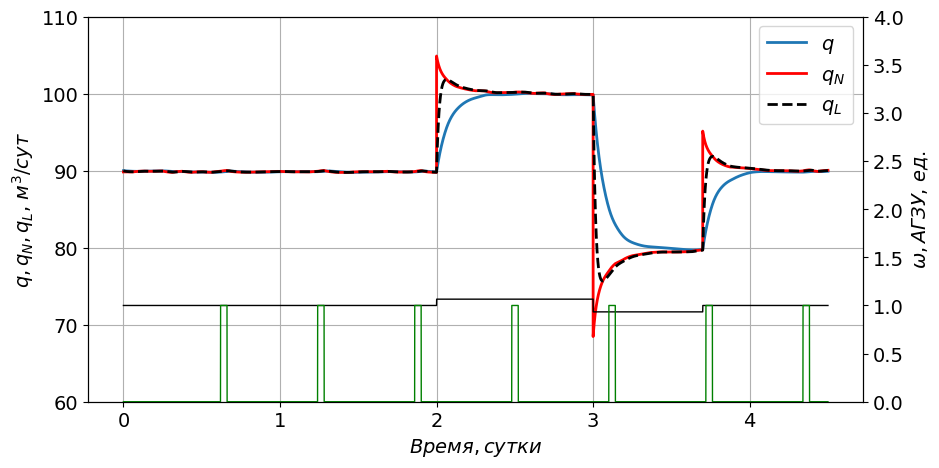

In [5]:
plot_data = [
             {'data': (
                PlotData(df['q'], '', 2, 'q'),
                PlotData(df['q_N'], 'r', 2, 'q_N'),
                PlotData(df['q_L'], 'k--', 2, 'q_L'),
              ), 'x': df['x'], 'y_scale': Scale(min=60, max=110), 'dt': dt, 'mu': 'м^3/сут'},
             {'data': (
               PlotData(df['u'], 'k', 1, '\omega'),
               PlotData(df['agzu'], 'g', 1, 'АГЗУ'),
              ), 'x': df['x'], 'y_scale': Scale(min=0, max=4), 'dt': dt, 'mu': 'ед.'},
            ]

plot = build_plot(plot_data)
plot.show()

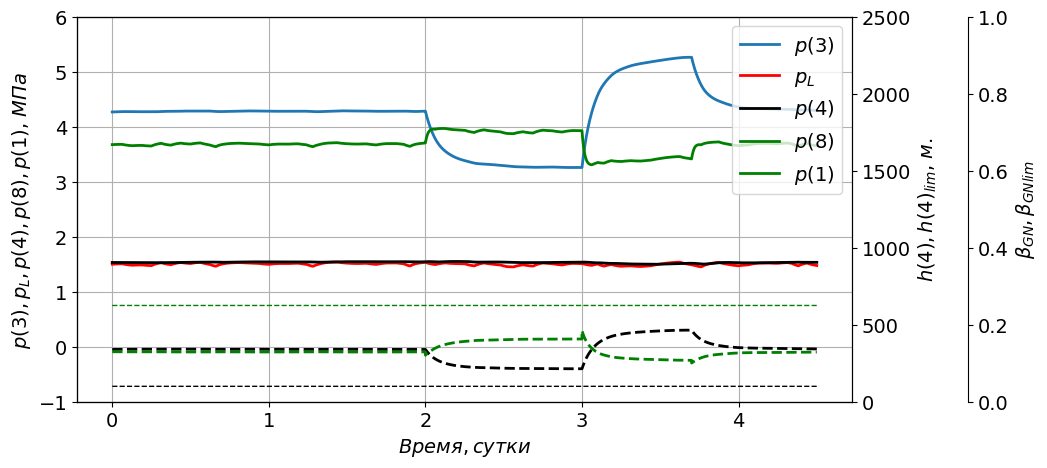

In [6]:
plot_data = [
            {'data': (
              PlotData(df['p_3'], '', 2, 'p(3)'),
              PlotData(df['p_L'], 'r', 2, 'p_L'),
              PlotData(df['p_4'], 'k', 2, 'p(4)'),
              PlotData(df['p_8'], 'g', 2, 'p(8)'),
              PlotData(df['p_1'], 'g', 2, 'p(1)'),
              ), 'x': df['x'], 'y_scale': Scale(min=-1, max=6), 'dt': dt, 'mu': 'МПа'},
            {'data': (
                PlotData(df['h_4'], 'k--', 2, 'h(4)'),
                PlotData(pd.Series([h_lim]*K_NUMBERS), 'k--', 1, 'h(4)_{lim}')
              ), 'x': df['x'], 'y_scale': Scale(min=0, max=2500), 'dt': dt, 'mu': 'м.'},
            {'data': (
                PlotData(df['betta_GN'], 'g--', 2, '\\beta_{GN}'),
                PlotData(pd.Series([betta_G_lim]*K_NUMBERS), 'g--', 1, '\\beta_{GNlim}')
              ), 'x': df['x'], 'y_scale':  Scale(min=0, max=1), 'dt': dt},
]


plot = build_plot(plot_data)
plot.show()

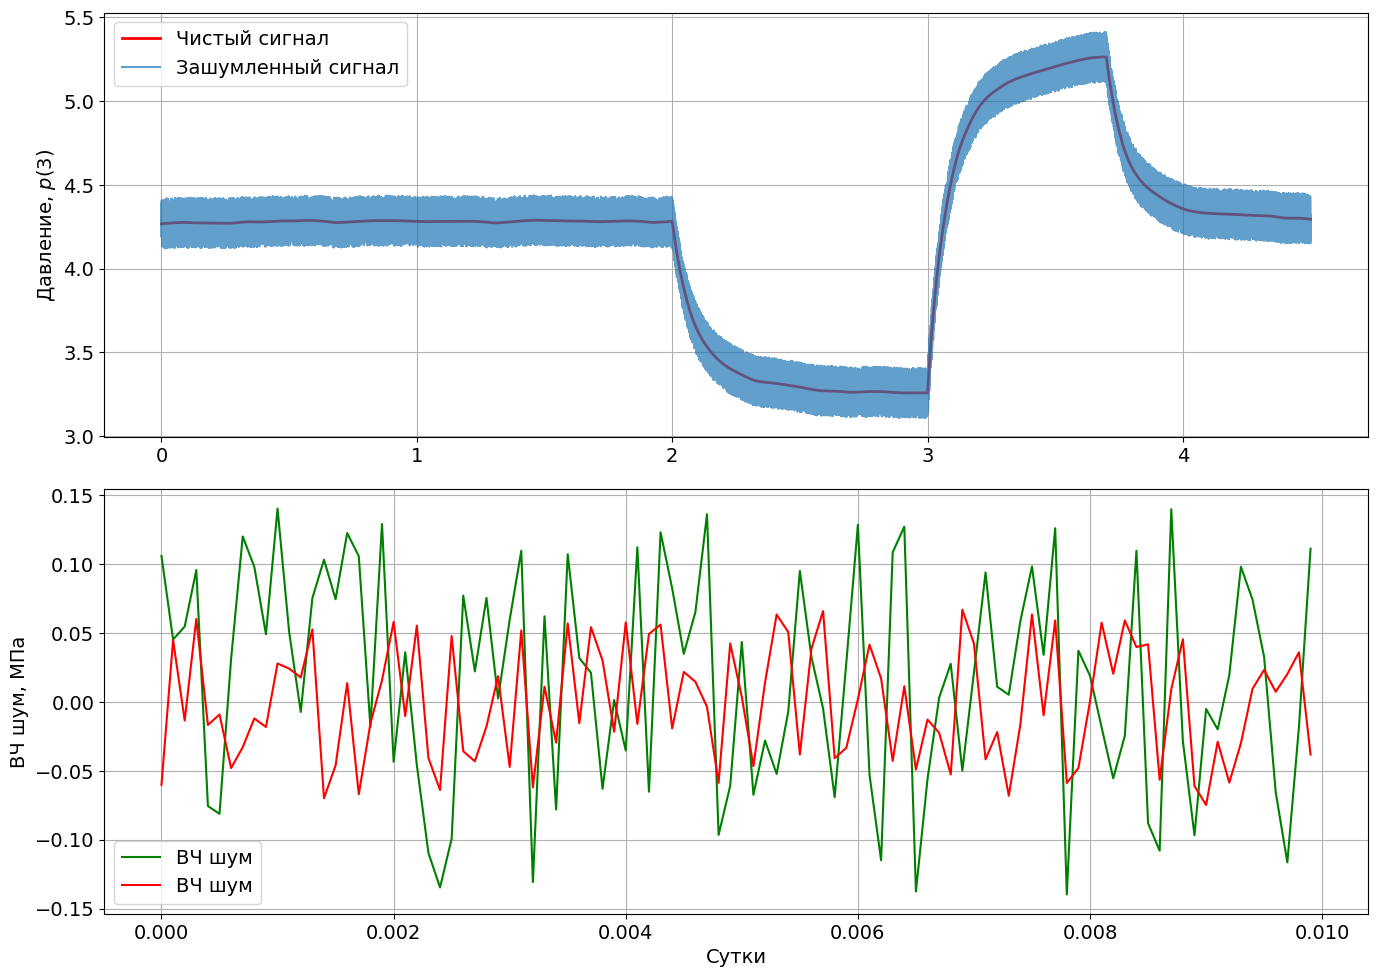

In [7]:
    from matplotlib import pyplot as plt
    # Добавление шумов
    clean_pressure = df['p_3']

    # Добавление шумов
    noisy_pressure, hf_noise = add_noise(clean_pressure, dt, hf_amplitude=0.1)
    noisy_pressure2, hf_noise2 = add_noise(clean_pressure, dt, hf_amplitude=0.05)

    # Визуализация
    plt.figure(figsize=(14, 10))

    # График давления
    plt.subplot(2, 1, 1)
    plt.plot(df['x'], clean_pressure, label='Чистый сигнал', color='r', lw=2)
    plt.plot(df['x'], noisy_pressure, label='Зашумленный сигнал', alpha=0.7)
    plt.ylabel('Давление, $p(3)$')

    plt.legend()
    plt.grid()

    # График ВЧ шума
    plt.subplot(2, 1, 2)
    plt.plot(df['x'][:100], hf_noise[:100], label='ВЧ шум', color='green')
    plt.plot(df['x'][:100], hf_noise2[:100], label='ВЧ шум', color='r')
    plt.ylabel('ВЧ шум, МПа')
    plt.xlabel('Сутки')
    plt.legend()
    plt.grid()


    plt.tight_layout()
    plt.show()

In [8]:
meter = Meter(dt)
meter.noise_enable = True
meter.noise_amplitude = 0.05
ident_dt, ident_k, df_ident = meter.measure(df, quant_step=None, denominator = 50)

In [9]:
#df_ident.to_excel("model_measure.xlsx")

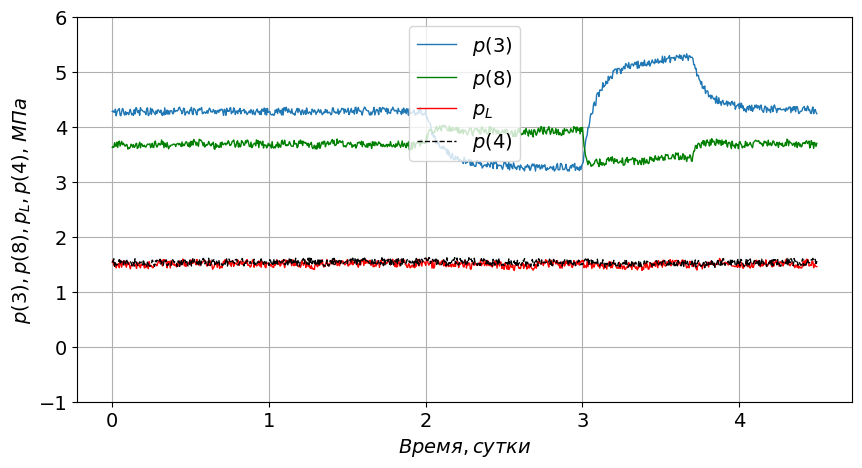

In [10]:
plot_data = [
            {'data': (
              PlotData(df_ident['p_3'], '', 1, 'p(3)'),
              PlotData(df_ident['p_8'], 'g', 1, 'p(8)'),
              PlotData(df_ident['p_L'], 'r', 1, 'p_L'),
              PlotData(df_ident['p_4'], 'k--', 1, 'p(4)'),
              ), 'x': df_ident['x'], 'y_scale': Scale(min=-1, max=6), 'dt': dt, 'mu': 'МПа'},
            ]

plot = build_plot(plot_data)
plot.show()

In [118]:
def calc_sco(p_R, r_1, r_2, reservoir):
  res = 0

  res += ((p_R/reservoir.p_R)-1)**2
  res += ((r_1/reservoir.r_1)-1)**2
  res += ((r_2/reservoir.r_2)-1)**2

  return float(res)

def calc_rsd(arr, true_val):

  error = 0
  for val in arr:
    error += (val - true_val)**2

  avg_error = np.sqrt(error / len(arr))

  return avg_error/true_val

def calc_rsd_by_series(series, true_val):
    return [calc_rsd(res, true_val) for res in series]

def calc_bias(arr, true_val):

    avg = arr.mean()

    return (avg - true_val)/true_val

def calc_bias_by_series(series, true_val):
    return [calc_bias(res, true_val) for res in series]

def calc_error(arr, true_val):
  avg = arr.mean()
  return round(abs(float(((true_val-avg)/true_val) * 100)), 2)

In [156]:
quant_step_list = [None]
denominator_list = [20]
experiment_num_max = 3

noise_list = np.arange(0, 0.5, 0.005)

denominator_list_minutes = [rec * dt * 24 * 60 for rec in denominator_list]

In [157]:
from identification.domain.model import ident_values, identificate, get_data_by_slices, identificate_regul, get_res_dict_for_ident

res = get_res_dict_for_ident(len(quant_step_list), len(denominator_list), len(noise_list), experiment_num_max)
res_regul = get_res_dict_for_ident(len(quant_step_list), len(denominator_list), len(noise_list), experiment_num_max)

meter = Meter(dt)
meter.noise_enable = True

for i, quant_step in enumerate(quant_step_list):
  for j, denominator in enumerate(denominator_list):
    for k, noise in enumerate(noise_list):
      for experiment_num in range(experiment_num_max):

        meter.noise_amplitude = noise
        ident_dt, ident_k, df_ident = meter.measure(df, quant_step=quant_step, denominator=denominator)

        calc_df = ident_values(ident_k, ident_dt, df_ident, well)
        b = identificate(calc_df, ident_k)

        s_times = [(0, 1)]
        calc_df_static = get_data_by_slices(calc_df, ident_dt, s_times)
        calc_df_static['_q_t'] = calc_df_static['_q_t'].mean()
        calc_df_static['p_1_t'] = calc_df_static['p_1_t'].mean()

        regul_times = [(1, 4.5)]
        calc_df_regul = get_data_by_slices(calc_df, ident_dt, regul_times)
        b_regul = identificate_regul(calc_df_regul, calc_df_static, well.reservoir.v_r, m2=1, m3=3*ident_k).T[0]

        res['p_R'][i, j, k, experiment_num] = b[0]
        res['r_1'][i, j, k, experiment_num] = b[1]
        res['r_2'][i, j, k, experiment_num] = b[2]

        res_regul['p_R'][i, j, k, experiment_num] = b_regul[0]
        res_regul['r_1'][i, j, k, experiment_num] = b_regul[1]
        res_regul['r_2'][i, j, k, experiment_num] = b_regul[2]

In [158]:
sco_p_R = calc_rsd_by_series(res['p_R'][0,0], well.reservoir.p_R)
sco_r_1 = calc_rsd_by_series(res['r_1'][0,0], well.reservoir.r_1)
sco_r_2 = calc_rsd_by_series(res['r_2'][0,0], well.reservoir.r_2)
sco = [sco_p_R[i] + sco_r_1[i] + sco_r_2[i] for i in range(len(sco_p_R))]


regul_sco_p_R = calc_rsd_by_series(res_regul['p_R'][0,0], well.reservoir.p_R)
regul_sco_r_1 = calc_rsd_by_series(res_regul['r_1'][0,0], well.reservoir.r_1)
regul_sco_r_2 = calc_rsd_by_series(res_regul['r_2'][0,0], well.reservoir.r_2)
regul_sco = [regul_sco_p_R[i] + regul_sco_r_1[i] + regul_sco_r_2[i] for i in range(len(sco_p_R))]

In [159]:
noise_list *= 100

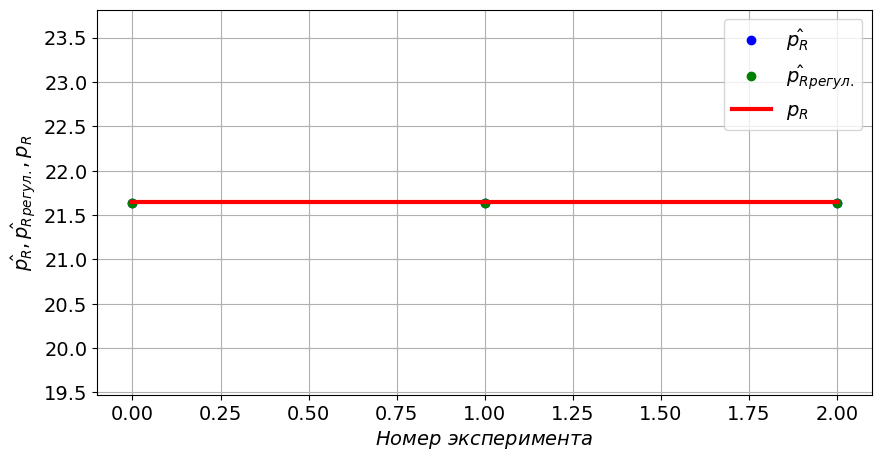

In [160]:
plot_data = [

            {'data': (
                PlotData(res['p_R'][0,0,0], 'bo', 1, '\^{p_R}'),
                PlotData(res_regul['p_R'][0,0,0], 'go', 1, '\^{p_R}_{регул.}'),
                PlotData(pd.Series([well.reservoir.p_R]*experiment_num_max), 'r', 3, 'p_R')
              ), 'x': range(experiment_num_max), 'dt': 1},

]


plot = build_plot(plot_data)
plot.xlabel('$Номер\ эксперимента$')
plot.show()

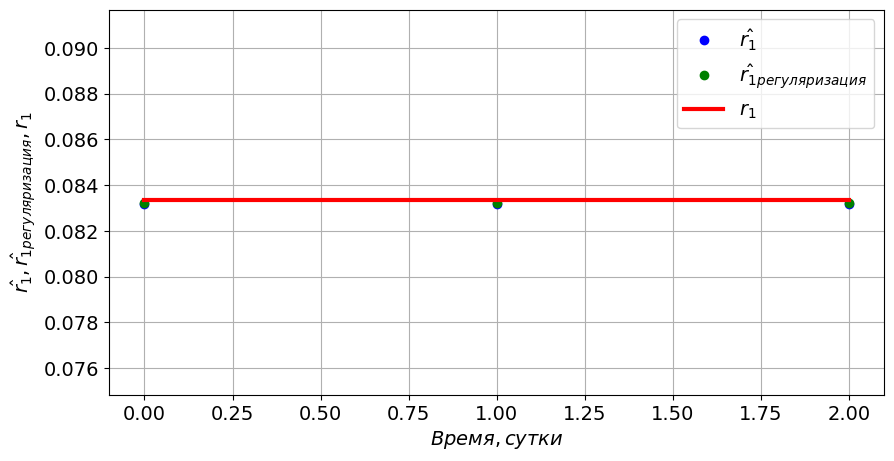

In [161]:
plot_data = [

            {'data': (
                PlotData(res['r_1'][0,0,0], 'bo', 1, '\^{r_1}'),
                PlotData(res_regul['r_1'][0,0,0], 'go', 1, '\^{r_1}_{регуляризация}'),
                PlotData(pd.Series([well.reservoir.r_1]*experiment_num_max), 'r', 3, 'r_1')
              ), 'x': range(experiment_num_max), 'dt': 1},

]


plot = build_plot(plot_data)
plot.show()

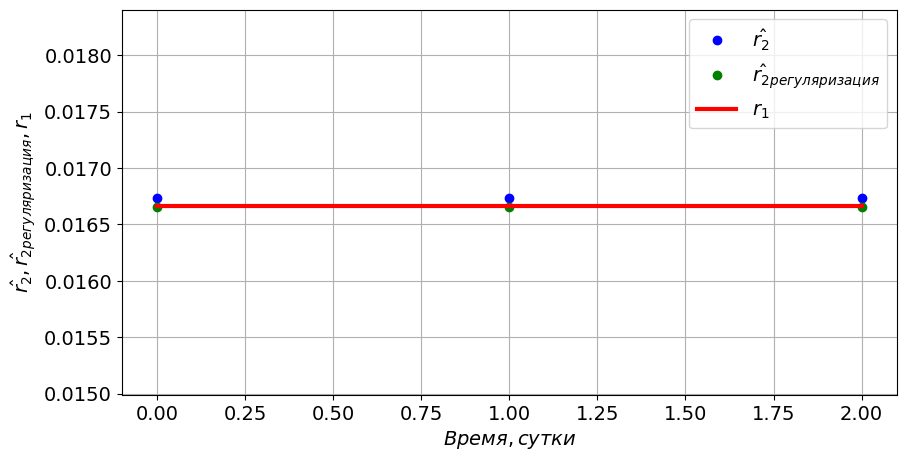

In [162]:
plot_data = [

            {'data': (
                PlotData(res['r_2'][0,0,0], 'bo', 1, '\^{r_2}'),
                PlotData(res_regul['r_2'][0,0,0], 'go', 1, '\^{r_2}_{регуляризация}'),
                PlotData(pd.Series([well.reservoir.r_2]*experiment_num_max), 'r', 3, 'r_1')
              ), 'x': range(experiment_num_max), 'dt': 1},

]


plot = build_plot(plot_data)
plot.show()

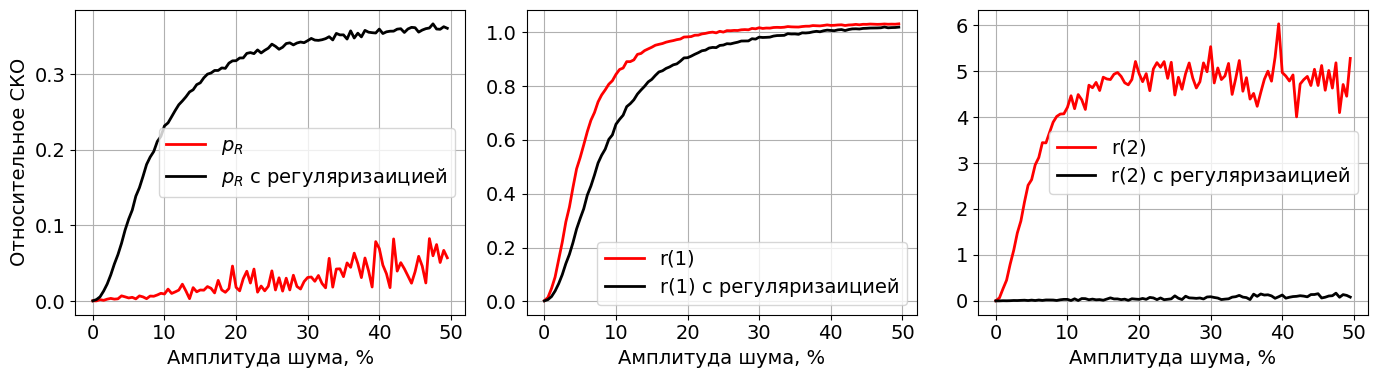

In [163]:
    # Визуализация
    plt.figure(figsize=(14, 4))

    # График давления
    plt.subplot(1, 3, 1)
    plt.plot(noise_list, sco_p_R, label='$p_R$', color='r', lw=2)
    plt.plot(noise_list, regul_sco_p_R, label='$p_R$ с регуляризаицией', color='k', lw=2)
    plt.xlabel('Амплитуда шума, %')
    plt.ylabel('Относительное СКО')
    plt.legend()
    plt.grid()


    # График НЧ шума
    plt.subplot(1, 3, 2)
    plt.plot(noise_list, sco_r_1, label='r(1)', color='r', lw=2)
    plt.plot(noise_list, regul_sco_r_1, label='r(1) с регуляризаицией', color='k', lw=2)
    plt.xlabel('Амплитуда шума, %')
    plt.legend()
    plt.grid()

    # График ВЧ шума
    plt.subplot(1, 3, 3)
    plt.plot(noise_list, sco_r_2, label='r(2)', color='r', lw=2)
    plt.plot(noise_list, regul_sco_r_2, label='r(2) с регуляризаицией', color='k', lw=2)
    plt.xlabel('Амплитуда шума, %')
    plt.legend()
    plt.grid()


    plt.tight_layout()
    plt.show()

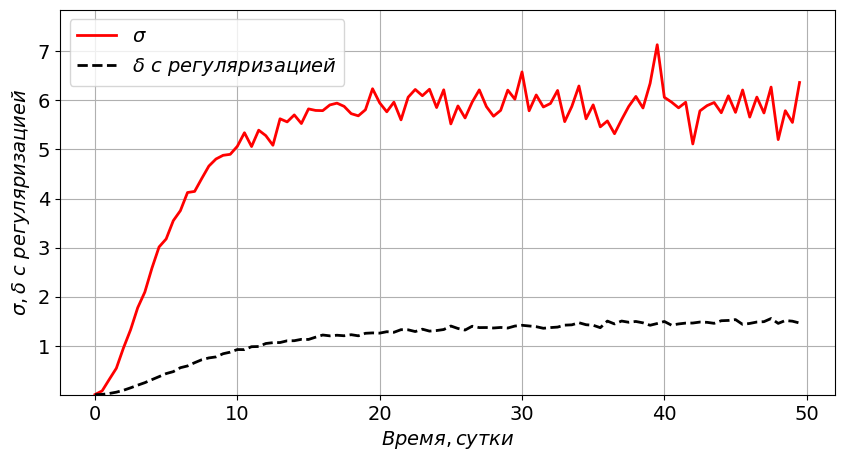

In [164]:

plot_data = [
            {'data': (
              PlotData(pd.Series(sco), 'r', 2, '\sigma'),
              PlotData(pd.Series(regul_sco), 'k--', 2, '\delta\\ с\\ регуляризацией'),
              ), 'x': noise_list, 'dt': 1},
            ]

plot = build_plot(plot_data)
plot.show()

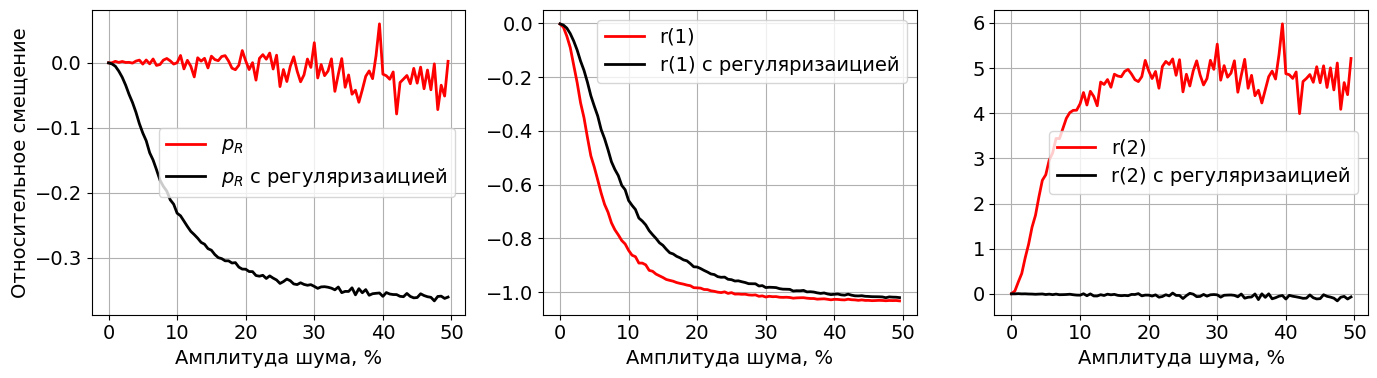

In [165]:
    # Визуализация
    plt.figure(figsize=(14, 4))

    # График давления
    plt.subplot(1, 3, 1)
    plt.plot(noise_list, calc_bias_by_series(res['p_R'][0,0], well.reservoir.p_R), label='$p_R$', color='r', lw=2)
    plt.plot(noise_list, calc_bias_by_series(res_regul['p_R'][0,0], well.reservoir.p_R), label='$p_R$ с регуляризаицией', color='k', lw=2)
    plt.xlabel('Амплитуда шума, %')
    plt.ylabel('Относительное смещение')
    plt.legend()
    plt.grid()

    # График НЧ шума
    plt.subplot(1, 3, 2)
    plt.plot(noise_list, calc_bias_by_series(res['r_1'][0,0], well.reservoir.r_1), label='r(1)', color='r', lw=2)
    plt.plot(noise_list, calc_bias_by_series(res_regul['r_1'][0,0], well.reservoir.r_1), label='r(1) с регуляризаицией', color='k', lw=2)
    plt.xlabel('Амплитуда шума, %')
    plt.legend()
    plt.grid()

    # График ВЧ шума
    plt.subplot(1, 3, 3)
    plt.plot(noise_list, calc_bias_by_series(res['r_2'][0,0], well.reservoir.r_2), label='r(2)', color='r', lw=2)
    plt.plot(noise_list, calc_bias_by_series(res_regul['r_2'][0,0], well.reservoir.r_2), label='r(2) с регуляризаицией', color='k', lw=2)
    plt.xlabel('Амплитуда шума, %')
    plt.legend()
    plt.grid()


    plt.tight_layout()
    plt.show()

In [166]:
errors = {'p_R': calc_error(res['p_R'][0,0,0], well.reservoir.p_R),
          'r_1': calc_error(res['r_1'][0,0,0], well.reservoir.r_1),
          'r_2': calc_error(res['r_2'][0,0,0], well.reservoir.r_2),
         }
errors

{'p_R': 0.05, 'r_1': 0.22, 'r_2': 0.38}

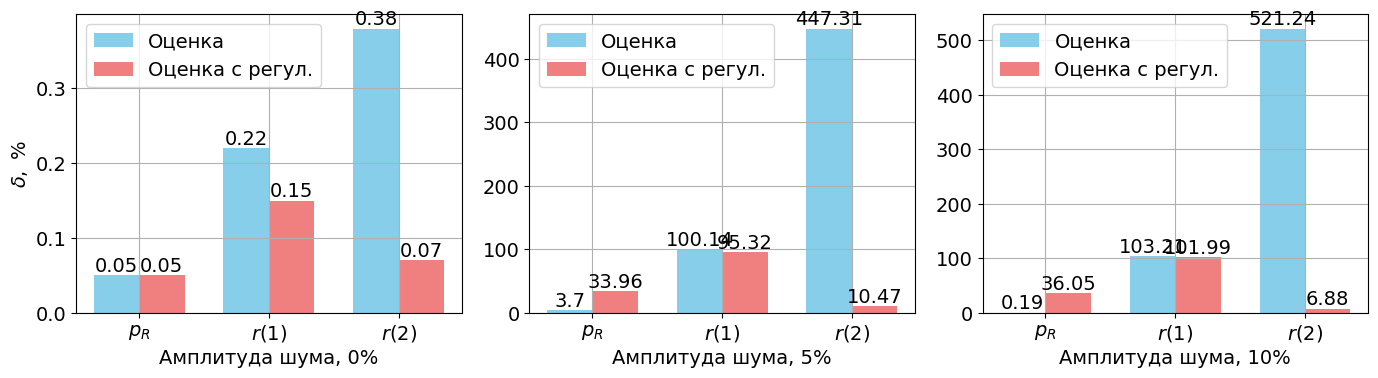

In [167]:
    # Визуализация
    plt.figure(figsize=(14, 4))

    categories = ['$p_R$', '$r(1)$', '$r(2)$']
    # Настройки отображения
    bar_width = 0.35  # Ширина столбца
    x = np.arange(len(categories))

    # График давления
    ax = plt.subplot(1, 3, 1)

    n = 0
    data1 = [calc_error(res['p_R'][0,0,n], well.reservoir.p_R), 
             calc_error(res['r_1'][0,0,n], well.reservoir.r_1), 
             calc_error(res['r_2'][0,0,n], well.reservoir.r_2)]
    data2 = [calc_error(res_regul['p_R'][0,0,n], well.reservoir.p_R), 
             calc_error(res_regul['r_1'][0,0,n], well.reservoir.r_1), 
             calc_error(res_regul['r_2'][0,0,n], well.reservoir.r_2)]
    bars1 = ax.bar(x - bar_width/2, data1, bar_width, label='Оценка', color='skyblue')
    bars2 = ax.bar(x + bar_width/2, data2, bar_width, label='Оценка с регул.', color='lightcoral')

    # Добавляем подписи значений над столбцами
    ax.bar_label(bars1, label_type='edge')
    ax.bar_label(bars2, label_type='edge')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    plt.xlabel('Амплитуда шума, 0%')
    plt.ylabel('$\delta,\ \%$')
    plt.grid()
    plt.legend()


    # График НЧ шума
    ax = plt.subplot(1, 3, 2)
    n = len(noise_list)//2
    data1 = [calc_error(res['p_R'][0,0,n], well.reservoir.p_R), 
             calc_error(res['r_1'][0,0,n], well.reservoir.r_1), 
             calc_error(res['r_2'][0,0,n], well.reservoir.r_2)]
    data2 = [calc_error(res_regul['p_R'][0,0,n], well.reservoir.p_R), 
             calc_error(res_regul['r_1'][0,0,n], well.reservoir.r_1), 
             calc_error(res_regul['r_2'][0,0,n], well.reservoir.r_2)]
    bars1 = ax.bar(x - bar_width/2, data1, bar_width, label='Оценка', color='skyblue')
    bars2 = ax.bar(x + bar_width/2, data2, bar_width, label='Оценка с регул.', color='lightcoral')

    # Добавляем подписи значений над столбцами
    ax.bar_label(bars1, label_type='edge')
    ax.bar_label(bars2, label_type='edge')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    plt.xlabel('Амплитуда шума, 5%')
    plt.grid()
    plt.legend()

    # График ВЧ шума
    ax = plt.subplot(1, 3, 3)
    n = -1
    data1 = [calc_error(res['p_R'][0,0,n], well.reservoir.p_R), 
             calc_error(res['r_1'][0,0,n], well.reservoir.r_1), 
             calc_error(res['r_2'][0,0,n], well.reservoir.r_2)]
    data2 = [calc_error(res_regul['p_R'][0,0,n], well.reservoir.p_R), 
             calc_error(res_regul['r_1'][0,0,n], well.reservoir.r_1), 
             calc_error(res_regul['r_2'][0,0,n], well.reservoir.r_2)]
    bars1 = ax.bar(x - bar_width/2, data1, bar_width, label='Оценка', color='skyblue')
    bars2 = ax.bar(x + bar_width/2, data2, bar_width, label='Оценка с регул.', color='lightcoral')

    # Добавляем подписи значений над столбцами
    ax.bar_label(bars1, label_type='edge')
    ax.bar_label(bars2, label_type='edge')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    plt.xlabel('Амплитуда шума, 10%')
    plt.grid()
    plt.legend()


    plt.tight_layout()
    plt.show()

In [168]:
#from scipy.ndimage import gaussian_filter
#mse = res['sco']
#MSE_smoothed = gaussian_filter(mse, sigma=1.5)
#
#X, Y = np.meshgrid(denominator_list_minutes,  quant_step_list)
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=30, azim=30)
#ax.plot_surface(X, Y, MSE_smoothed, cmap='viridis', alpha=0.85)
#ax.set_xlabel('$dt_и$, минут')
#ax.set_ylabel('Квант')
#plt.show()

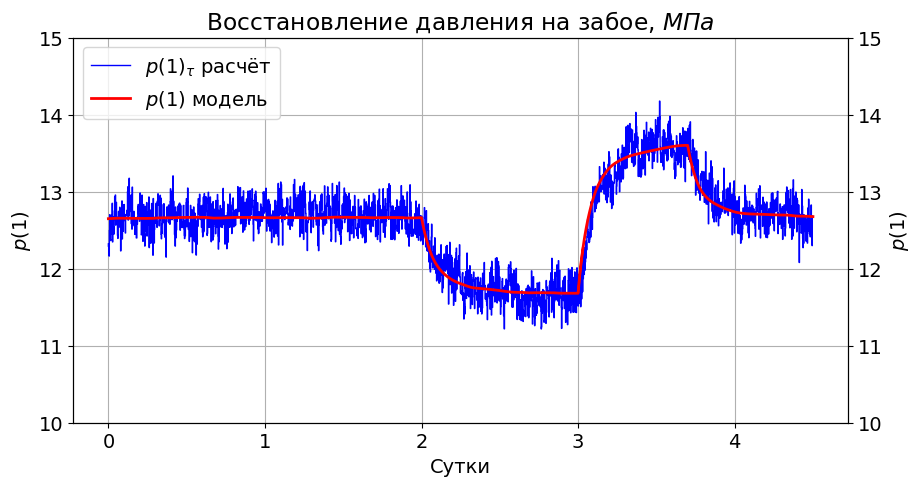

In [169]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p2, = twin1.step(df['x'], df['p_1'], 'r', lw=2, label="$p(1)$ модель")
p1, = ax.step(df_ident['x'], calc_df['p_1_t'], 'b', lw=1, label=r"$p(1)_\tau$ расчёт")


ax.set(ylim=(10, 15), xlabel="Сутки", ylabel="$p(1)$")
twin1.set(ylim=(10, 15), ylabel="$p(1)$")

plt.title('Восстановление давления на забое, $МПа$')

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()



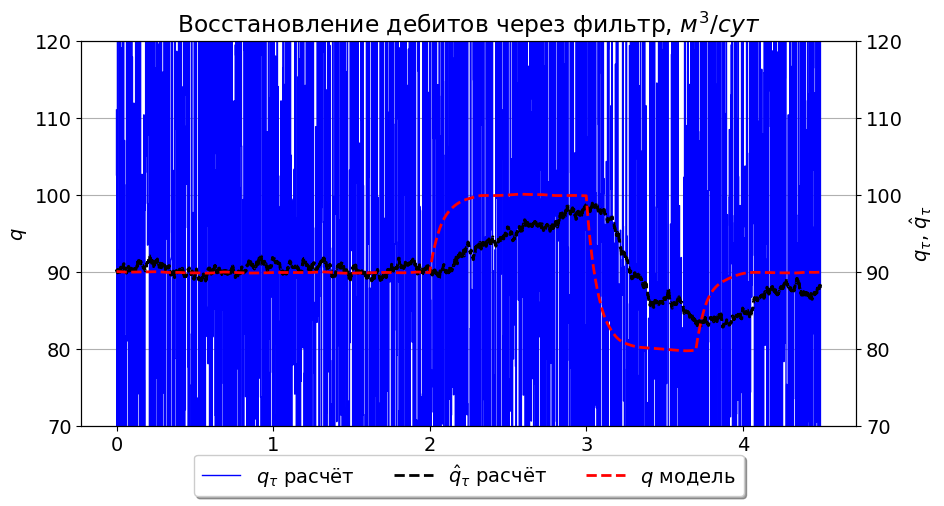

In [170]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.step(df_ident['x'], calc_df['q_t'], 'b', lw=1, label=r"$q_\tau$ расчёт")
p2, = ax.step(df_ident['x'], calc_df['_q_t'], 'k--', lw=2, label=r"$\^{q}_\tau$ расчёт")
p3, = twin1.plot(df['x'], df['q'], 'r--', lw=2, label="$q$ модель")


ax.set(ylim=(70, 120), xlabel="Сутки", ylabel="$q$")
twin1.set(ylim=(70, 120), ylabel=r"$q_\tau$, $\^{q}_\tau$")

plt.title('Восстановление дебитов через фильтр, $м^3/сут$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3])
ax.grid()
plt.show()

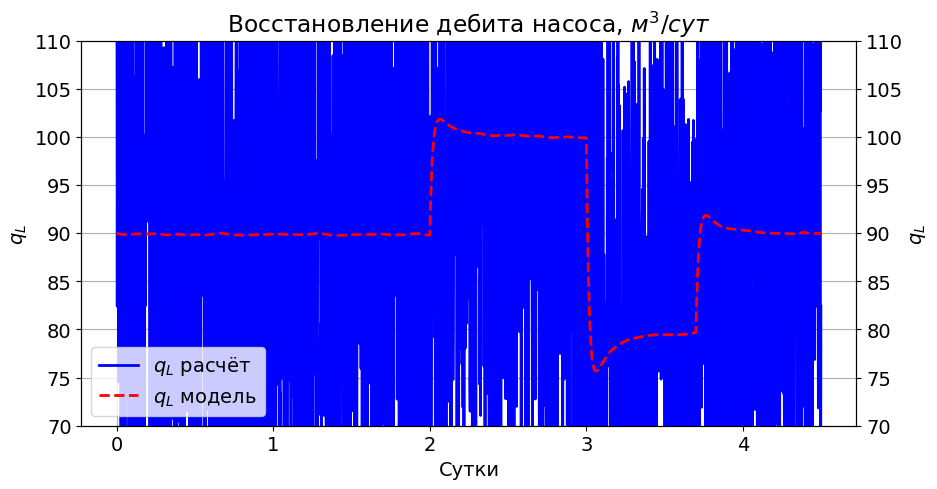

In [171]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(df_ident['x'], calc_df['q_L'], 'b', lw=2, label=r"$q_L$ расчёт")
p2, = ax.plot(df['x'], df['q_L'], 'r--', lw=2, label="$q_L$ модель")

ax.set(ylim=(70, 110), xlabel="Сутки", ylabel="$q_L$")
twin1.set(ylim=(70, 110), ylabel=r"$q_L$")

plt.title('Восстановление дебита насоса, $м^3/сут$')

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()

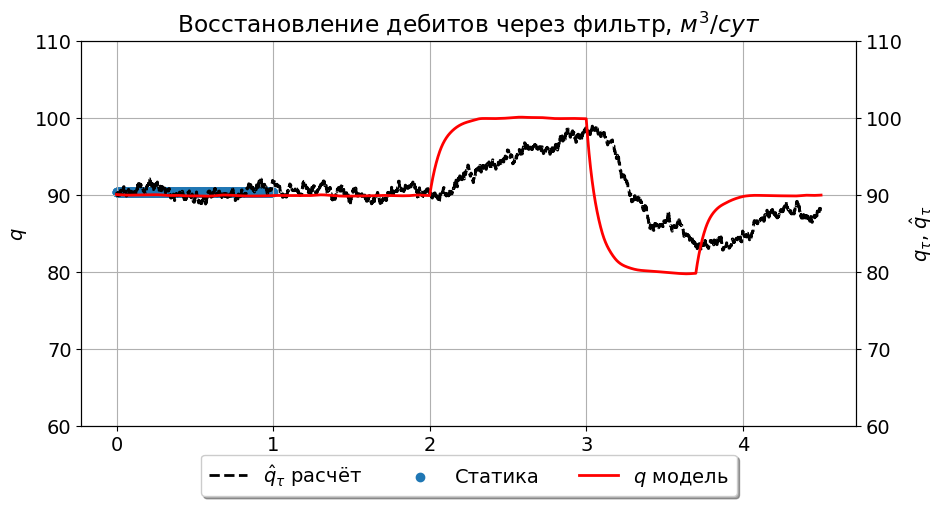

In [172]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

s_time = calc_df_static['_q_t'].index * denominator * dt

p1, = ax.step(df_ident['x'], calc_df['_q_t'], 'k--', lw=2, label=r"$\^{q}_\tau$ расчёт")
p2 = ax.scatter(s_time, calc_df_static['_q_t'], label=r"Статика")
p3, = twin1.plot(df['x'], df['q'], 'r', lw=2, label="$q$ модель")


ax.set(ylim=(60, 110), xlabel="Сутки", ylabel="$q$")
twin1.set(ylim=(60, 110), ylabel=r"$q_\tau$, $\^{q}_\tau$")

plt.title('Восстановление дебитов через фильтр, $м^3/сут$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3])
ax.grid()
plt.show()